# Lab 3: Clustering, Association Rules or Recommenders

## National Footprint Accounts 2018: The Ecological Footprint of 196 Countries

### Travis Deason, Michael Landrum, & Vanessa Torres

## Functions and Imports required for Project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline
plt.style.use('ggplot')

from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabaz_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
class ColorCycle(object):
    '''
    Used in matplotlib plotting objects, generates diffirent marker and color for each label
    --------
    METHODS
    nc - next color
        returns string to represent color as item in ["b","g","r","c","m","y","k","w"]
    nm - next marker
        returns string to represent color as item in 
        ['.', ',', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', '8', 's']
    '''
    def __init__(self):
        self.colors = ["b","g", "r","c","m","y","k"]
        self.markers = ['.', 'o', 'v', '1', '2', '<', '3', '4', ',', '8', 's']
        self.color_len = len(self.colors) - 1
        self.color_pos = 0
        self.marker_pos = 0
        self.marker_len = len(self.markers) - 1
    def nc(self):
        if self.color_pos == self.color_len:
            self.color_pos = 0
        else:
            self.color_pos += 1
        return self.colors[self.color_pos]

    def nm(self):
        if self.marker_pos == self.marker_len:
            self.marker_pos = 0
        else:
            self.marker_pos += 1
        return self.markers[self.marker_pos]
cc = ColorCycle()

def cluster_year(df, model, year=2014, cond=None, **modelkwargs):
    '''
    --------
    PARAMETERS
    df: pd.DataFrame
        -  
    year: int
        -  year of interest
    cond
        -  regex pattern to match (gdp and population will be added by default)
    model
        -  SkLearn model type
    model_kwargs
        -  arguements for SkLearn Model
    --------
    RETURNS
    df: pd.DataFrame
        -  reduced by cond with label column added
    imodel: SkLearn Model
        -  Model Trained on the data
    '''
    if cond is None:
        cond = ".*"
    cols = [col for col in df.columns if re.search(cond, col)  or len(col.split('_')) == 1]
    i_df = df[cols].set_index('country').query("year == " + str(year)).drop('year', axis=1)
    imodel = model(**modelkwargs)\
                    .fit(
                        df[cols].query("year == " + str(year))\
                                .set_index('country').drop('year', axis=1) 
                        )
    i_df['label'] =  imodel.labels_
    return i_df, imodel

def plot_cluster(df, cc=cc, title=None, ax=None, fig=None):
    '''
    Generate a scatter plot of multi-dimensional cluster using Principal Component
    Analysis to reduce plot to two dimensions
    --------
    INPUTS
    df: pd.DataFrame
        - Dataframe which has been fitted to a cluster of all continous values must contain 'label' col
    cc: ColorCycle object
        - required for observing class types
    --------
    RETURNS
    figure, ax object containing the plot
    '''
    pca = PCA(n_components=2)
    _2df = pca.fit_transform(df)
    _2df = np.insert(_2df, 2, df['label'].values, axis=1)
    if ax == None:
        fig, ax = plt.subplots(1,1, figsize=(16,8))
    for cls, color in enumerate(df['label'].unique()):
        cons_tmp = _2df[_2df[:,2] == cls]
        ax.scatter(cons_tmp[:,0], 
                   cons_tmp[:,1], 
                   color= cc.nc(),
                   marker= cc.nm(),
                   label="class = {}".format(cls));
    if title:
        ax.set_title(title)
    ax.legend();
    return fig, ax


def return_top_n(df, sort_col, sample_size=2):
    '''
    Prints n observations from each label group ordered by sort col
    '''
    all_dfs = []
    label_order = df.groupby('label')\
        .agg({sort_col : 'mean', 'gdp' : 'count'})\
        .sort_values(sort_col, ascending=False).index
    for i in label_order:
        try:
            all_dfs.append(df[df['label'] == i].sample(sample_size))
        except ValueError:
            all_dfs.append(df[df['label'] == i])
    return pd.concat(all_dfs)

## Business Understanding 1 -- 10

 - Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?).
 - How will you measure the effectiveness of a good algorithm? 
 - Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?

The Global Footprint Network, is an international nonprofit organization, whose mission is to help end ecological overshoot by making ecological limits central to decision-making. Founded in 2003, they have engaged with more than 50 nations, 30 cities, and 70 global partners to deliver scientific insights that have driven high-impact policy and investmet decisions; the heart of their work is the Ecological Footprint. 

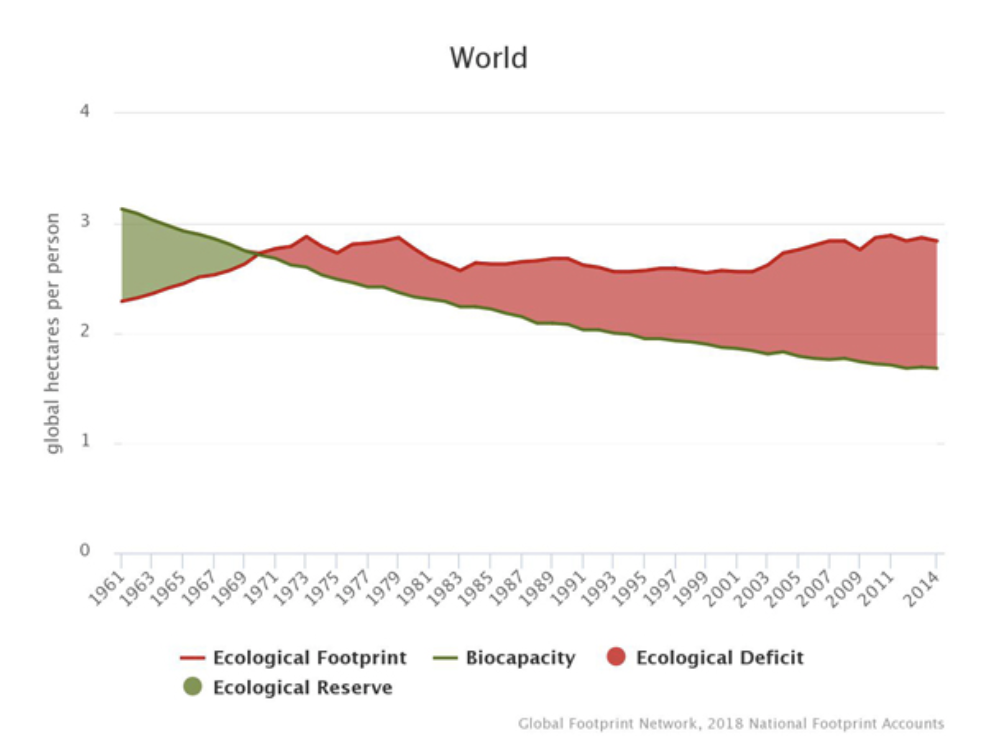


Data set taken from https://www.kaggle.com/footprintnetwork/national-footprint-accounts-2018.

In [3]:
footprint_df = pd.read_csv("data/national_footprint_data.csv", encoding='ISO-8859-14')
footprint_df.sample(10)

,country,ISO alpha-3 code,UN_region,UN_subregion,year,record,crop_land,grazing_land,forest_land,fishing_ground,built_up_land,carbon,total,Percapita GDP (2010 USD),population
52192,Namibia,NAM,Africa,Southern Africa,1988,EFConsPerCap,NaN,NaN,NaN,NaN,NaN,NaN,1.664220e+00,3666.330,1304000
76531,Turkey,TUR,Asia,Western Asia,1964,BiocapTotGHA,2.568121e+07,6.728922e+06,4.235665e+07,3.331030e+06,4.728010e+05,0.000000,7.857062e+07,3542.430,30293000
86061,World,NaN,World,World,1997,BiocapTotGHA,3.063073e+09,1.569584e+09,5.371895e+09,1.093695e+09,2.984936e+08,0.000000,1.139674e+10,7700.890,5894155000
11884,Canada,CAN,North America,North America,2009,EFExportsPerCap,1.986996e+00,1.446157e-01,2.077565e+00,1.230723e-01,0.000000e+00,2.129848,6.462098e+00,46543.800,33747000
69242,Spain,ESP,Europe,Southern Europe,1961,EFConsPerCap,6.414072e-01,2.478348e-01,2.414140e-01,3.694666e-01,1.443460e-02,0.796591,2.311148e+00,8155.170,30777000
81585,Viet Nam,VNM,Asia,South-Eastern Asia,1979,EFExportsTotGHA,2.194487e+05,7.022010e-01,0.000000e+00,5.122589e+04,0.000000e+00,957796.756300,1.228472e+06,NaN,53170000
15991,Congo,COG,Africa,Middle Africa,1969,BiocapTotGHA,2.673880e+05,1.374832e+07,3.264132e+07,1.585912e+06,2.151417e+04,0.000000,4.826445e+07,1579.010,1296000
1168,Albania,ALB,Europe,Southern Europe,2000,EFProdPerCap,2.874467e-01,1.824393e-01,6.927292e-02,6.502449e-03,1.883756e-02,0.349043,9.135422e-01,2337.940,3122000
46971,Mali,MLI,Africa,Western Africa,1996,BiocapTotGHA,4.999384e+06,9.886462e+06,4.792848e+06,7.403156e+05,5.289573e+05,0.000000,2.094797e+07,517.087,9901000
38180,Jamaica,JAM,Latin America and the Caribbean,Caribbean,1984,BiocapPerCap,NaN,NaN,NaN,NaN,NaN,NaN,4.992073e-01,3617.540,2284000


In [4]:
footprint_df['country'].unique().size

196

In [5]:
footprint_df['year'].unique().size

54

In [6]:
footprint_df['UN_region'].unique().size

7

In [7]:
footprint_df['UN_subregion'].unique().size

23

Our dataset spans 54 years and includes 196 total countries.

"In this data set we show results for 196 countries (including "World") for data years 1961 through 2014, the most recent year with complete data. For each country and year, we report Ecological Footprint of Consumption, also just called Ecological Footprint, and Biocapacity ("Biocap...","EFCons...") as well as Ecological Footprint of Production ("EFProd...") and trade ("EFImports...", "EFExports...") in both total global hectares and global hectares per capita ("...TotGHA","...PerCap")."

The original purpose of this data set was to track the Ecological Footprints of the countries as time went on. We are going to use this data to cluster similar countries to each other. This dataset tracks data using 10 methods for each year across as many of the 196 countries that data can be collected for
 - The 10 methods are:
    - BioCapPerCap: Biocapacity in global hectares (gha) divided by population
    - BiocapTotGHA: Total biocapacity in global hectares (gha)
    - EFConsPerCap: Ecological Footprint of consumption in global hectares (gha) divided by population
    - EFConsTotGHA: Total Ecological Footprint of consumption in global hectares (gha)
    - Human Development Index (HDI): HDI = Human Development Index; Source: Trends in the Human Development Index, 1980-2014, downloaded 2/24/2017 from http://hdr.undp.org/en/composite/trends
    - Gross Domestic Product (GDP): Gross Domestic Product per capita, current prices; Source: World Economic Outlook database - by countries, downloaded 2/24/2017 from http://www.imf.org/external/pubs/ft/weo/2015/02/weodata/download.aspx
    - Data Quality Score: Quality of overall country data as assessed by NFA researchers. For more detail, seehttp://www.footprintnetwork.org/data-quality-scores/

## Data Understanding 1 -- 10

 - Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file.
 - Verify data quality:
     - Are there missing values? 
     - Duplicate data? 
     - Outliers? Are those mistakes? How do you deal with these problems?

In [8]:
footprint_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87020 entries, 0 to 87019
Data columns (total 15 columns):
country                     87020 non-null object
ISO alpha-3 code            85660 non-null object
UN_region                   87020 non-null object
UN_subregion                87020 non-null object
year                        87020 non-null int64
record                      87020 non-null object
crop_land                   63530 non-null float64
grazing_land                63530 non-null float64
forest_land                 63530 non-null float64
fishing_ground              63530 non-null float64
built_up_land               63530 non-null float64
carbon                      63530 non-null float64
total                       87020 non-null float64
Percapita GDP (2010 USD)    71410 non-null float64
population                  87020 non-null int64
dtypes: float64(8), int64(2), object(5)
memory usage: 10.0+ MB


The following columns contain null values
* ISO alpha-3 code
* *crop_land*
* *grazing_land*
* *forest_land*
* *fishing_land*
* *built_up_land*
* *carbon*
* *total*
* Percapita GDP

rows in italic all contain the same amount of null values


It appears that some values were left as NA because they were not recorded in those countries on the given year. Using the value of built_up_land as an example, can see that the value remains N/A for some countries in all cases

In [9]:
footprint_df[footprint_df['carbon'].fillna('N') == "N"].groupby('country').max()\
    ['year'].value_counts()

2013    29
2014    23
1992     2
1991     2
Name: year, dtype: int64

In [10]:
footprint_df[(footprint_df['carbon'].fillna('N') == "N") &
            (footprint_df['year'] == 2013)]['country'].unique()

array(['Algeria', 'Antigua and Barbuda', 'Bermuda', 'Botswana', 'Aruba',
       'Bulgaria', 'Cabo Verde', 'Cayman Islands', 'Comoros', 'Cyprus',
       'Dominica', 'Ecuador', 'Egypt', 'Finland', 'French Guiana',
       'French Polynesia', 'Djibouti', 'Gabon', 'Grenada', 'Guatemala',
       'Honduras', 'Hungary', 'Iran, Islamic Republic of', 'Iraq',
       'Jamaica', 'Kyrgyzstan', 'Cambodia', 'Martinique', 'Mauritania',
       'Mauritius', 'Mongolia', 'Morocco',
       'Micronesia, Federated States of', 'Namibia', 'Papua New Guinea',
       'Timor-Leste', 'RÃ©union', 'Sao Tome and Principe', 'Senegal',
       'South Africa', 'Tajikistan', 'Swaziland', 'Turkmenistan', 'Tonga',
       'Trinidad and Tobago', 'Ukraine', 'Uruguay', 'Samoa'], dtype=object)

In [11]:
footprint_df[(footprint_df['carbon'].fillna('N') == "N") &
            (footprint_df['year'] == 1992)]['country'].unique()

array(['Algeria', 'Antigua and Barbuda', 'Bermuda', 'Botswana', 'Aruba',
       'Bulgaria', 'Cabo Verde', 'Comoros', 'Cyprus', 'Czechoslovakia',
       'Dominica', 'Ecuador', 'Egypt', 'Ethiopia PDR', 'Finland',
       'French Polynesia', 'Djibouti', 'Gabon', 'Guatemala', 'Honduras',
       'Hungary', 'Iran, Islamic Republic of', 'Iraq', 'Jamaica',
       'Kyrgyzstan', 'Cambodia', 'Martinique', 'Mauritania', 'Mauritius',
       'Mongolia', 'Morocco', 'Namibia', 'Papua New Guinea', 'Timor-Leste',
       'RÃ©union', 'Sao Tome and Principe', 'Senegal', 'South Africa',
       'Tajikistan', 'Swaziland', 'Turkmenistan', 'Tonga',
       'Trinidad and Tobago', 'Ukraine', 'Uruguay', 'Samoa'], dtype=object)

* It looks like 1991, 1992, 2013, and 2014 are years where there wasn't a whole lot of information reported.
* 1991 and 1992 seems to be related to wars in the middle east and the fall of the Soviet empire.  Evidence of this is maifest in the fact that countries which no longer exist, such as Czechoslovakia and Yugoslav SFR are null in this year. Data from these years may be less valuable due to all the missing information.  

* Since we are interested in the values which are N/A on these countries and dates, we will drop these values, and make a note that those years may have incomplete data

In [12]:
foot_limited = footprint_df.loc[footprint_df['carbon'].fillna('N') != "N"]

In [13]:
foot_limited.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63530 entries, 0 to 87019
Data columns (total 15 columns):
country                     63530 non-null object
ISO alpha-3 code            62490 non-null object
UN_region                   63530 non-null object
UN_subregion                63530 non-null object
year                        63530 non-null int64
record                      63530 non-null object
crop_land                   63530 non-null float64
grazing_land                63530 non-null float64
forest_land                 63530 non-null float64
fishing_ground              63530 non-null float64
built_up_land               63530 non-null float64
carbon                      63530 non-null float64
total                       63530 non-null float64
Percapita GDP (2010 USD)    54870 non-null float64
population                  63530 non-null int64
dtypes: float64(8), int64(2), object(5)
memory usage: 7.8+ MB


In [14]:
foot_limited[foot_limited['Percapita GDP (2010 USD)'].fillna('N') == 'N']['country'].value_counts()

Guadeloupe                                540
Somalia                                   540
Syrian Arab Republic                      540
Korea, Democratic People's Republic of    540
Sudan (former)                            500
Afghanistan                               410
Haiti                                     350
Barbados                                  290
Poland                                    290
Yemen                                     290
Romania                                   290
Lebanon                                   270
Guinea                                    250
Angola                                    240
Tanzania, United Republic of              240
Viet Nam                                  230
Lao People's Democratic Republic          230
Uganda                                    210
Libyan Arab Jamahiriya                    210
Qatar                                     200
Albania                                   190
Switzerland                       

A remaining 8670 rows are null for Percapita GDP
These are spread across 47 countries.
* Observing these data, it appears many of the countries were sites of long term conflict zones during the period such as Lebanon, Somalia, and Syria; while others are isolated states which do not participate significently to global trade such as North Korea and Cuba.  Switzerland and Lithuania seem outliers in this dataset as they have had stable consistant governace in place througout the observation period.

* So that these observations do not throw off the total dataset, each of these observations will be set to the average for the year which they were observed.

In [15]:
for year in foot_limited['year'].unique():
    foot_limited.loc[(foot_limited['Percapita GDP (2010 USD)'].fillna('NA') == 'NA')
                     & (foot_limited['year'] == year), 'Percapita GDP (2010 USD)'] \
            = foot_limited[foot_limited['year'] == year]['Percapita GDP (2010 USD)'].mean()

In [16]:
foot_limited.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63530 entries, 0 to 87019
Data columns (total 15 columns):
country                     63530 non-null object
ISO alpha-3 code            62490 non-null object
UN_region                   63530 non-null object
UN_subregion                63530 non-null object
year                        63530 non-null int64
record                      63530 non-null object
crop_land                   63530 non-null float64
grazing_land                63530 non-null float64
forest_land                 63530 non-null float64
fishing_ground              63530 non-null float64
built_up_land               63530 non-null float64
carbon                      63530 non-null float64
total                       63530 non-null float64
Percapita GDP (2010 USD)    63530 non-null float64
population                  63530 non-null int64
dtypes: float64(8), int64(2), object(5)
memory usage: 7.8+ MB


* The only remiaining Null values are now within the 'ISO alpha-3 code' column.  Since this column is redundant, we will remove it for the remainder of our analysis

#### Data Understanding 1 Summary
* Values were null for PerCapita GDP and land/carbon records.
* Since our primary interest in clustering was land/carbon records, we could not perform analysis on observations were all data is missing; so we dropped these rows.  These rows were primarily in the following years
   * 1991
   * 1992
   * 2013
   * 2014
* PerCapita GDP nulls were more sparse, and this column is considered less critical.  For the most part there seems to be a trend in Null values, but the GDP factor of that trend is unlikley to have a large effect on our study. If we were doing supervised machine learning we would set these to an arbritary value such as -1 and add a dummy value to signify these observations were null, but since we are simply trying to observe patterns within the data using unsupervised clustering, we set the data to be the mean value for the given year which it was observed

## Data Understanding 2 --10
 - Visualize the any important attributes appropriately
 
 Important: Provide an interpretation for any charts or graphs.

 - For a start, we are only going to focus on PerCap statistics (meaning we will normalize the size of each country) in order to reduce each country in a given year to a single row, we will also reduce all the land variables to Production, Consumption, Imports and Exports and normalize each of these values by total land capacity.

In [17]:
t_df = foot_limited.set_index(['country', 'year']).iloc[:,3:-2]

In [18]:
rec_name = 'Exports'

In [19]:
footprint_df[footprint_df['record'] == 'EF{}PerCap'.format(rec_name)]\
    ['built_up_land'].value_counts()

0.0    6353
Name: built_up_land, dtype: int64

* The value for built-up land is 0 for all imports and exports; so we can ommit this column in import and export data since is only has a single value

In [20]:
### Pivot all land use columns about a given country for a year and drop the record column
out_lst = []
for rec_name in ['Cons', 'Prod', 'Exports', 'Imports']:
    p_df = t_df[t_df['record'] == 'EF{}PerCap'.format(rec_name)].iloc[:,1:]
    p_df.columns = ["{}_".format(rec_name[:4].lower()) + x for x  in p_df.columns]
    out_lst.append(p_df)
pivoted_df = pd.concat(out_lst, axis=1)
pivoted_df.drop(['impo_built_up_land', 'expo_built_up_land'], axis=1, inplace=True)
## this one runs a bit slow
rel_cols = foot_limited.columns[[2, 3, -2, -1]].tolist()
pivoted_df[rel_cols] = foot_limited.groupby(['country', 'year']).max()[rel_cols]

In [21]:
full_df = pivoted_df.reset_index()

In [22]:
full_df.columns

Index(['country', 'year', 'cons_crop_land', 'cons_grazing_land',
       'cons_forest_land', 'cons_fishing_ground', 'cons_built_up_land',
       'cons_carbon', 'cons_total', 'prod_crop_land', 'prod_grazing_land',
       'prod_forest_land', 'prod_fishing_ground', 'prod_built_up_land',
       'prod_carbon', 'prod_total', 'expo_crop_land', 'expo_grazing_land',
       'expo_forest_land', 'expo_fishing_ground', 'expo_carbon', 'expo_total',
       'impo_crop_land', 'impo_grazing_land', 'impo_forest_land',
       'impo_fishing_ground', 'impo_carbon', 'impo_total', 'UN_region',
       'UN_subregion', 'Percapita GDP (2010 USD)', 'population'],
      dtype='object')

In [23]:
for year in full_df['year'].unique():
    full_df.loc[(full_df['Percapita GDP (2010 USD)'].fillna(-1) == -1)
                     & (full_df['year'] == year), 'Percapita GDP (2010 USD)'] \
               = full_df[full_df['year'] == year]['Percapita GDP (2010 USD)'].mean()
        
    full_df.loc[(full_df['population'].fillna(-1) == -1)
                 & (full_df['year'] == year), 'population'] \
        = full_df[full_df['year'] == year]['population'].mean()

In [24]:
ncols = list(full_df.columns)
ncols[-2] = 'gdp_percapita'

In [25]:
full_df.columns = ncols

In [26]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6353 entries, 0 to 6352
Data columns (total 32 columns):
country                6353 non-null object
year                   6353 non-null int64
cons_crop_land         6353 non-null float64
cons_grazing_land      6353 non-null float64
cons_forest_land       6353 non-null float64
cons_fishing_ground    6353 non-null float64
cons_built_up_land     6353 non-null float64
cons_carbon            6353 non-null float64
cons_total             6353 non-null float64
prod_crop_land         6353 non-null float64
prod_grazing_land      6353 non-null float64
prod_forest_land       6353 non-null float64
prod_fishing_ground    6353 non-null float64
prod_built_up_land     6353 non-null float64
prod_carbon            6353 non-null float64
prod_total             6353 non-null float64
expo_crop_land         6353 non-null float64
expo_grazing_land      6353 non-null float64
expo_forest_land       6353 non-null float64
expo_fishing_ground    6353 non-null floa

 - Now we wil take a snapshot of a single year and see where many of the datapoints land

In [27]:
c2010 = full_df[full_df['year'] == 2010]

In [28]:
c_base = c2010.iloc[:,2:-1].drop(['UN_region','UN_subregion'], axis=1)

In [29]:
c_base.columns.shape

(27,)

#### We will use scatterplots to identify any trends in the data

* Beacuse there are 27 total columns, we will look at a subset of the columns in each scatterplot, first for crops, then forest, fishing, grazing and carbon


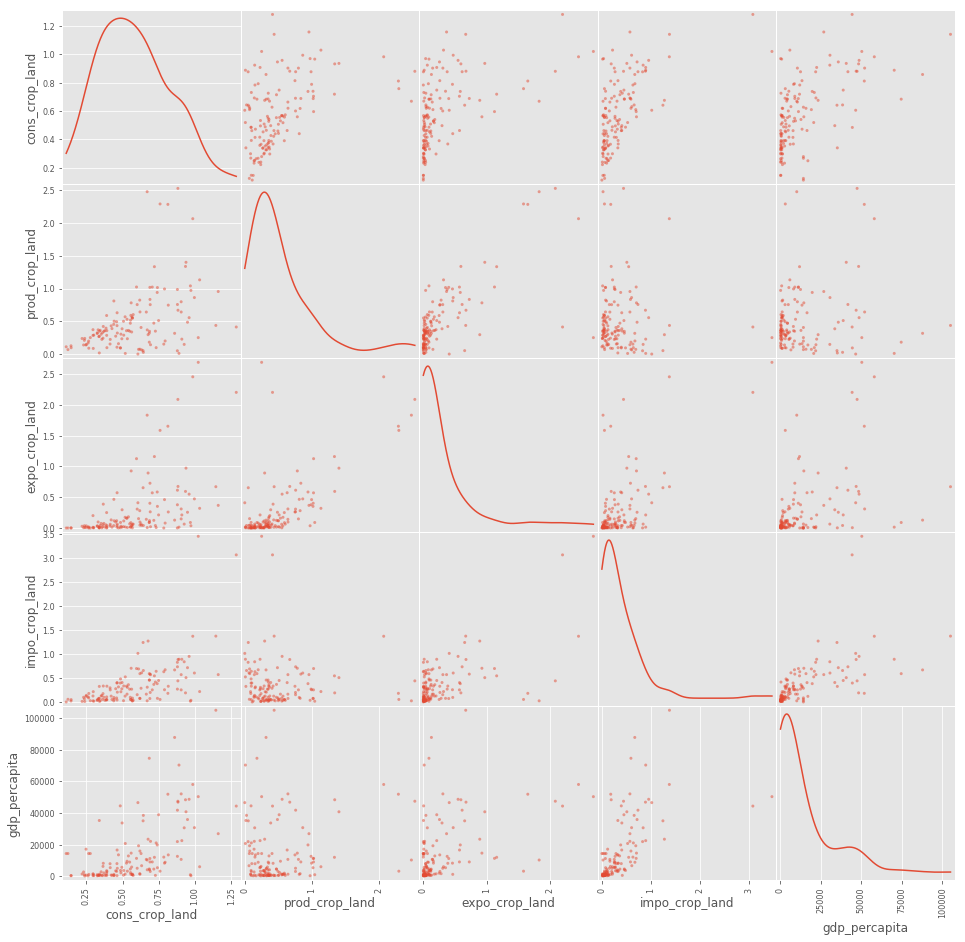

In [30]:
pd.plotting.scatter_matrix(
    c_base[
        [x for x in c_base.columns 
             if x.split('_')[1] == 'crop' or x == 'gdp_percapita']], 
    diagonal='kde',
    figsize=(16,16));


In [31]:
c2010.sort_values('prod_crop_land', ascending=False)\
    [[x for x in c2010.columns if x[5:9] == 'crop' or x == 'country']].head(9)

,country,cons_crop_land,prod_crop_land,expo_crop_land,impo_crop_land
917,Canada,0.881176,2.528664,2.088504,0.441016
235,Argentina,0.669590,2.477749,1.832389,0.024230
4186,Paraguay,0.758523,2.290991,1.585425,0.052957
289,Australia,0.812368,2.284579,1.652950,0.180738
1476,Denmark,0.983709,2.066126,2.455356,1.372938
1782,France,0.936998,1.400865,0.972205,0.508338
5739,United States of America,0.933601,1.337705,0.594269,0.190165
3199,Lithuania,0.719449,1.333901,1.160318,0.545866
1553,Belarus,1.030931,1.132861,0.319646,0.217716


 - The trend in crop land indicates that, while many countries produce crops at a reate that is sustainable, there is a cluster of countries which consume more then they produce, and there is a small group of 6 countries which produce far more than they consume.

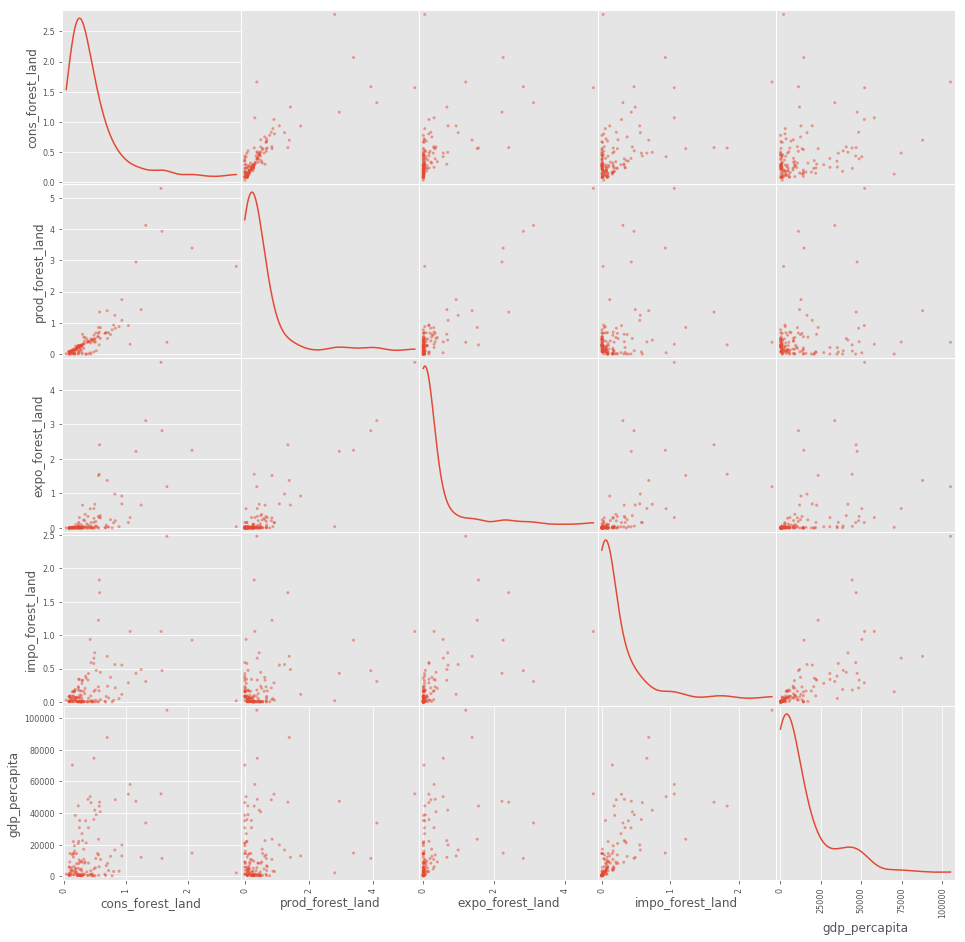

In [32]:
pd.plotting.scatter_matrix(
    c_base[
    [x for x in c_base.columns if x.split('_')[1] == 'forest' or x == 'gdp_percapita']
        ], 
    diagonal='kde',
    figsize=(16,16));

In [33]:
c2010.sort_values('expo_forest_land', ascending=False)\
    [[x for x in c2010 if x[5:11] == 'forest' or x == 'country']].head(6)

,country,cons_forest_land,prod_forest_land,expo_forest_land,impo_forest_land
5133,Sweden,1.566047,5.300256,4.789100,1.054891
3786,New Zealand,1.318599,4.115173,3.103669,0.307095
2931,Latvia,1.581417,3.928300,2.815988,0.469104
343,Austria,0.573060,1.343091,2.404954,1.634924
1673,Estonia,2.066787,3.390392,2.247948,0.924343
917,Canada,1.160725,2.946555,2.214901,0.429072


 - There is a large variation in Forest land. A few countries appear to be both large importers and exporters of forest products, and a couple of countries are very large exporters of forest products. The largest propositional exporters of forest products appear to be The Scandanavian Countries, The Baltic States and Canada.

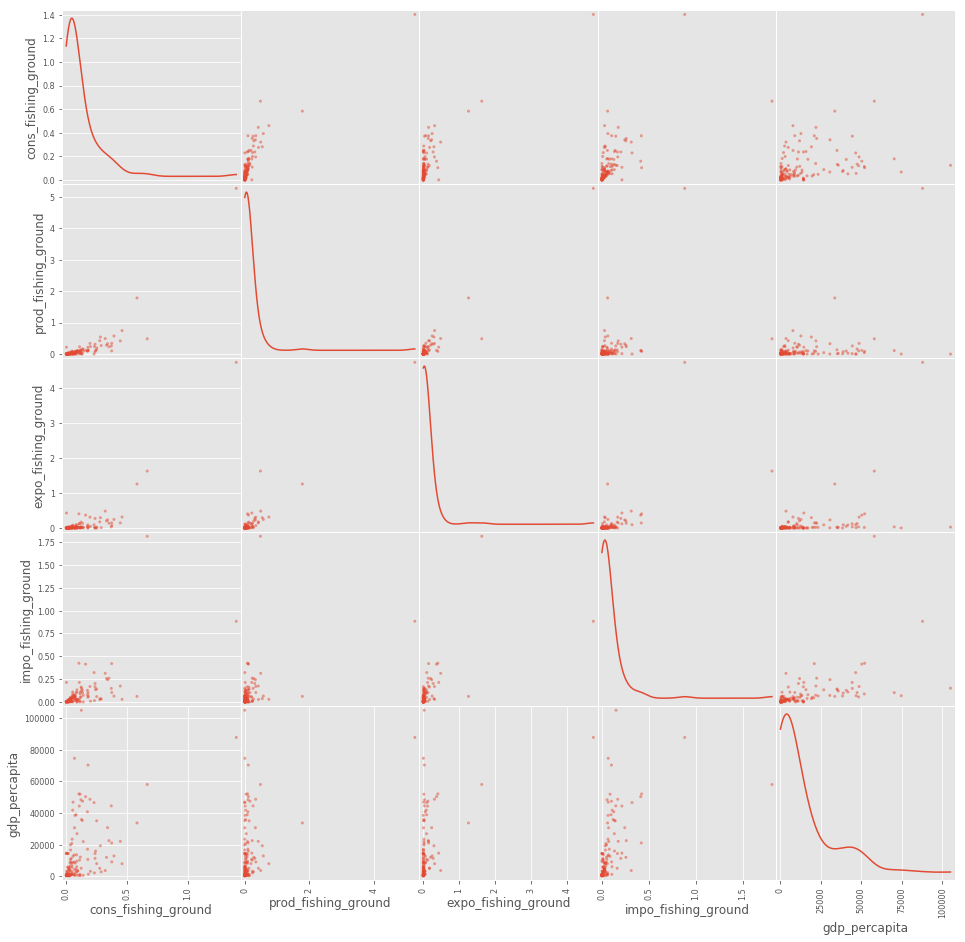

In [34]:
pd.plotting.scatter_matrix(
    c_base[
        [x for x in c_base.columns if x.split('_')[1] == 'fishing' or x == 'gdp_percapita']
            ],
    diagonal='kde',
    figsize=(16,16));

In [35]:
c2010.sort_values('prod_fishing_ground', ascending=False)\
    [[x for x in c2010 if x[5:12] == 'fishing' or x == 'country']].head(6)

,country,cons_fishing_ground,prod_fishing_ground,expo_fishing_ground,impo_fishing_ground
4001,Norway,1.401580,5.264271,4.745712,0.883021
3786,New Zealand,0.583478,1.783108,1.260605,0.060975
4109,Panama,0.460619,0.746248,0.314276,0.028648
1133,Chile,0.393610,0.574576,0.245334,0.064369
5433,Oman,0.282115,0.542499,0.296222,0.035838
1727,Fiji,0.321870,0.492834,0.484142,0.313178


 - Norway and New Zealand have the most productive fisharies. Both seem to be major exporters of their seafood production as well.

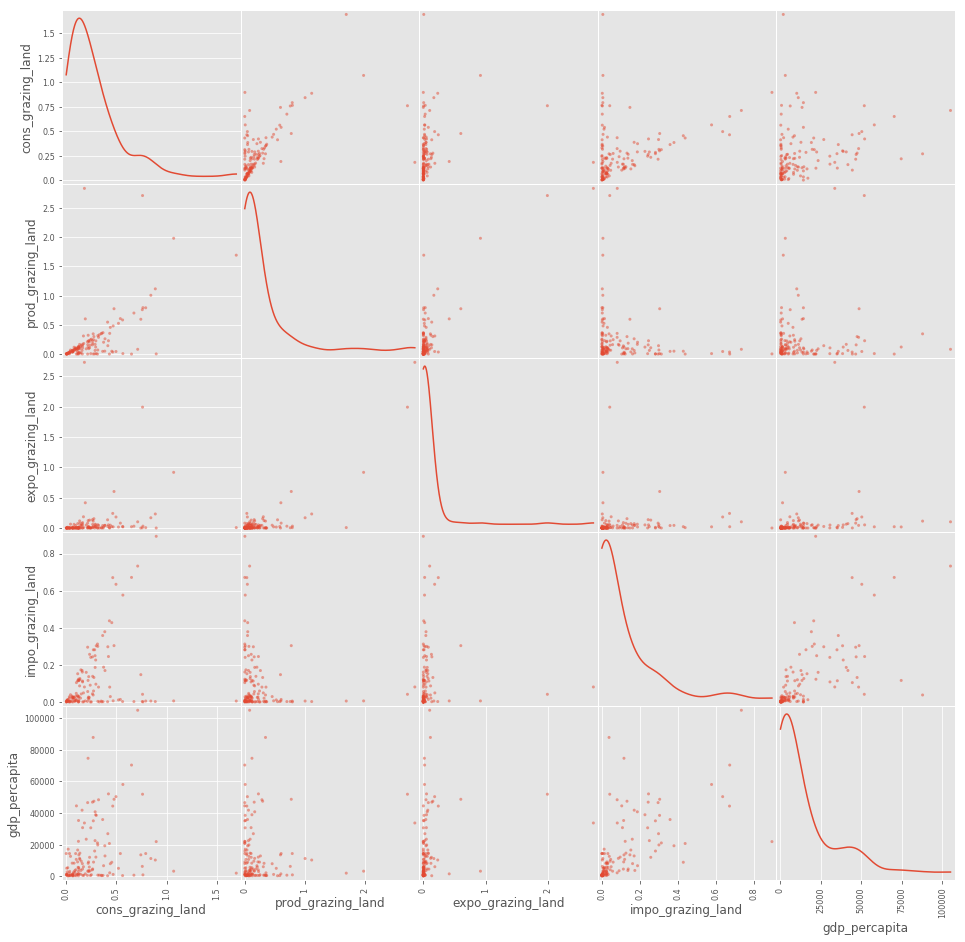

In [36]:
pd.plotting.scatter_matrix(
    c_base[
        [x for x in c_base.columns if x.split('_')[1] == 'grazing' or x == 'gdp_percapita']
        ], 
    diagonal='kde',
    figsize=(16,16));


In [37]:
c2010.sort_values('prod_grazing_land', ascending=False)\
    [[x for x in c2010 if x[5:12] == 'grazing' or x == 'country']].head(6)

,country,cons_grazing_land,prod_grazing_land,expo_grazing_land,impo_grazing_land
3786,New Zealand,0.182547,2.835205,2.733427,0.080769
289,Australia,0.759730,2.712495,1.994037,0.041272
4186,Paraguay,1.068564,1.981297,0.918333,0.005600
610,Bolivia,1.690142,1.692152,0.006976,0.004966
235,Argentina,0.886400,1.115828,0.231607,0.002179
665,Brazil,0.841970,1.006029,0.169053,0.004993


 - Australia/New Zealand stand as an outliers in exporting products derived from grazing land. There is also a cluster of Latin American countries that produce large amounts of grazing products for domestic consumption, as is generally the trend. There are also a group of small wealthy countries, and island nations; which are large importers of grazing products.
 - Otherwise countries which consume more grazing products tend to also be countries which produce as well. 

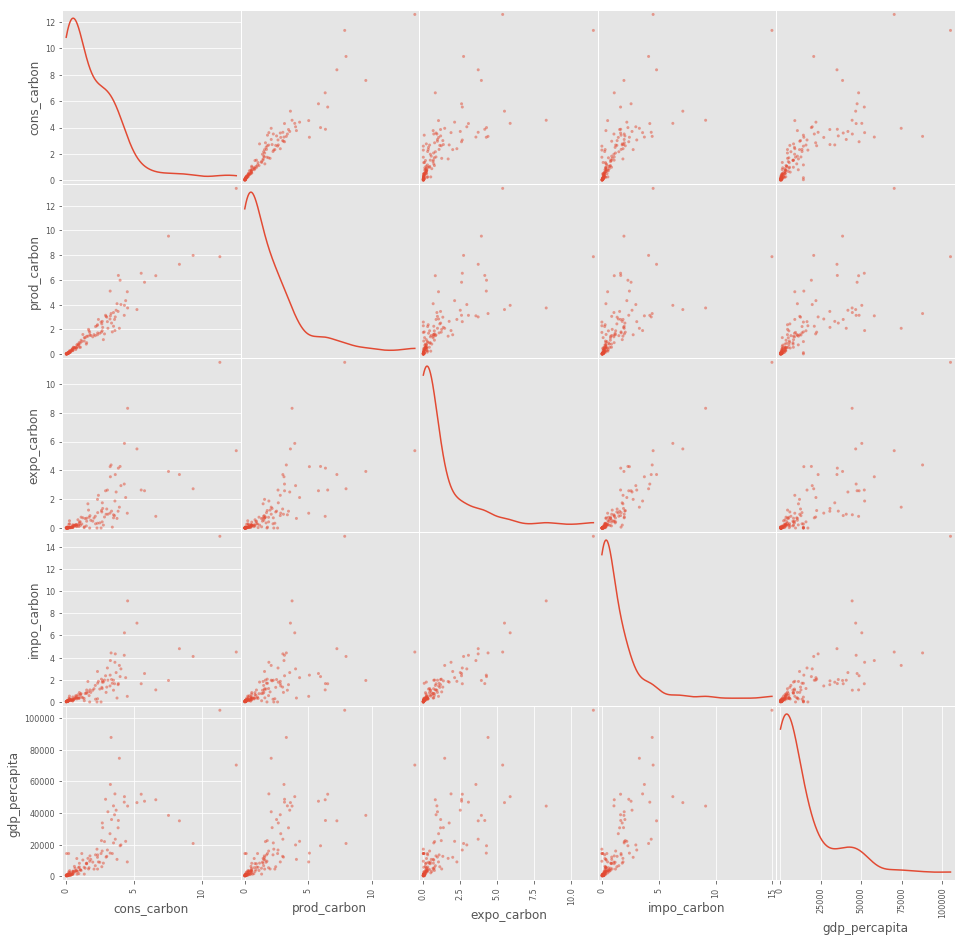

In [38]:
pd.plotting.scatter_matrix(
    c_base[
        [x for x in c_base.columns if x.split('_')[1] == 'carbon' or x == 'gdp_percapita']
            ], 
    diagonal='kde',
    figsize=(16,16));

In [39]:
c2010.sort_values('prod_carbon', ascending=False)\
    [[x for x in c2010 if x[5:11] == 'carbon' or x == 'country']].head(12)

,country,cons_carbon,prod_carbon,expo_carbon,impo_carbon
4507,Qatar,12.546180,13.404102,5.363944,4.506022
2908,Kuwait,7.558421,9.543159,3.924388,1.939650
422,Bahrain,9.371104,7.985363,2.721640,4.107381
6136,Luxembourg,11.339296,7.881174,11.494926,14.953049
5576,United Arab Emirates,8.361384,7.264704,3.710735,4.807416
289,Australia,5.548604,6.541778,2.636368,1.643194
700,Brunei Darussalam,3.868009,6.364521,4.153782,1.657270
5739,United States of America,6.622469,6.343231,0.809413,1.088651
5433,Oman,3.996116,5.977680,4.271159,2.289595
917,Canada,5.794214,5.813801,2.585409,2.565823


 - Not that this should come as a surprise, but the 5 largest proportional producers of Carbon products are on the Arabian penisula.
 - With a total of 35 parameters and only 140 countrties, we are likley to run into the curse of dimensionality; to combat this, we will first consolidate all the food catagories (fishing, grazing, and crop) into a single catagory. We will also consolidate the forest and carbon catagory; since these product types are both derived from natural resources. We will end up with three catagories. This is a bit of a generalization since not all crops are used for food, and forest products are not necessarily the same as oil, but it should be good enough to get the picture.
     - Resource
     - Food
     - Industry

In [40]:
df_comb = full_df.copy()

for colt in ['cons_{}', 'prod_{}', 'impo_{}', 'expo_{}']:
    df_comb[colt.format('food')] = \
        df_comb[colt.format('crop_land')] + \
        df_comb[colt.format('grazing_land')] + \
        df_comb[colt.format('fishing_ground')]
    df_comb[colt.format('resource')] = \
        df_comb[colt.format('forest_land')] +\
        df_comb[colt.format('carbon')]
    try: 
        df_comb[colt.format('industry')] = full_df[colt.format('built_up_land')]
    except:
        'nothing'
    df_comb.drop([x for x in full_df.columns if x[:5] == colt[:5] and x[-5:] != 'total'], axis=1, inplace=True)
df_comb.drop(['UN_region', 'UN_subregion'], axis=1, inplace=True)
df_comb['gdp'] = df_comb["gdp_percapita"]
df_comb['population'] = df_comb["population"] / df_comb['population'].max()
df_comb['gdp'] = df_comb['gdp'] / df_comb['gdp'].max()
df_comb.drop("gdp_percapita", axis=1, inplace=True)

## Modeling and Evaluation 1 -- 10

 - Train and adjust parameters
 - The first thing we can do is try to cluster countries by imports 
 - Since there are several categories here, we will go over the first category in detail and derive a function to analyze the remaining categories in more detail

In [41]:
consume_df = df_comb[[col for col in df_comb.columns if col[:4] == 'cons' or len(col.split('_')) == 1]]\
    .query("year == 2010").set_index('country').drop('year', axis=1)

In [42]:
consume_df['population'] = consume_df['population'] / consume_df['population'].max()
consume_df['gdp'] = consume_df['gdp'] / consume_df['gdp'].max()
# consume_df.loc[consume_df['gdp'].fillna('NA') == 'NA', 'gdp'] = consume_df['gdp'].mean()

In [43]:
model = KMeans(5)

In [44]:
model.fit(consume_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [45]:
pca = PCA(n_components=2)

consume_2d = pca.fit_transform(consume_df)
consume_2d = np.insert(consume_2d, 2, model.labels_, axis=1)

In [46]:
colors = ["black", 'Red', 'violet', 'green', 'orange', 'cyan', 'gold', 'silver']

In [47]:
consume_df['label'] = model.labels_

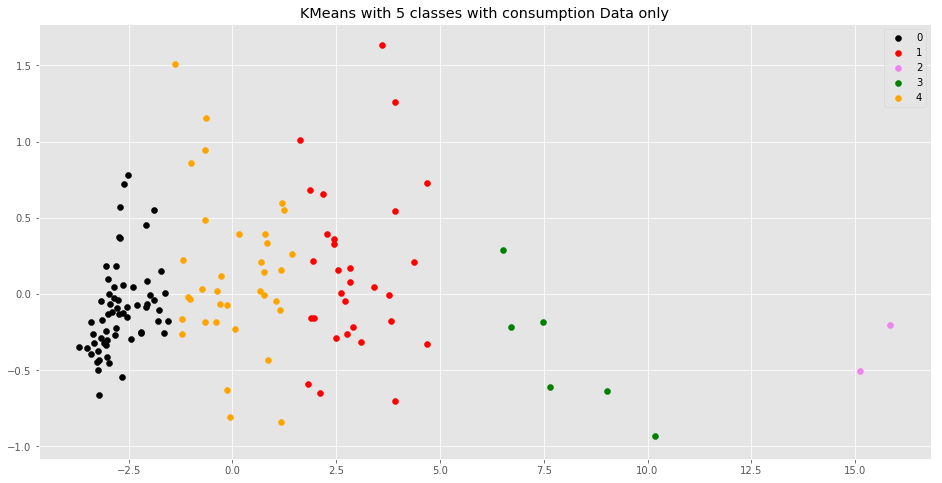

In [48]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
for cls, color in enumerate(colors[:5]):
    cons_tmp = consume_2d[consume_2d[:,2] == cls]
    ax.scatter(cons_tmp[:,0], cons_tmp[:,1], color=color, label=cls);
    ax.set_title('KMeans with 5 classes with consumption Data only')
ax.legend();

 - There are some pretty obvious clusters there, but the top two values are kind of outliers.

#### At the top of the Report, there are two functions export_df and exp_model.  They perform similar tasks to those done in the above lines, but allow us to generate models with just two lines of code.  We will no look at some of the other parameters in KMeans to determine if they create diffirent or more insightful clusters

#### Now Using all export data

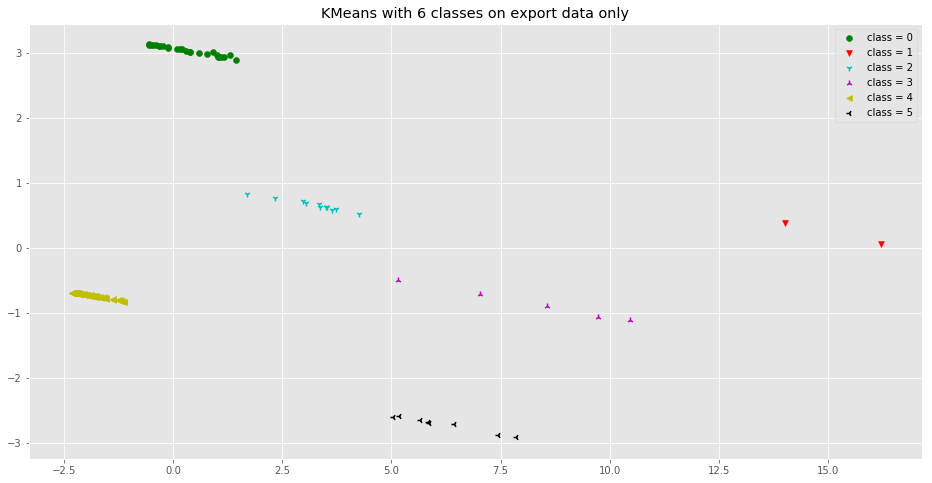

In [49]:
export_df, exp_model = cluster_year(df_comb, KMeans, year=2010, cond="^expo", n_clusters=6)
plot_cluster(export_df, title="KMeans with 6 classes on export data only");

In [50]:
return_top_n(export_df, 'expo_total', sample_size=2)

,expo_total,population,expo_food,expo_resource,gdp,label
country,,,,,,
Belgium,12.422777,0.001504,2.562642,9.860134,0.390389,1
Luxembourg,13.487775,0.000070,0.798713,12.689062,0.923321,1
Australia,6.457087,0.003050,3.662392,2.794696,0.456309,3
New Zealand,9.141135,0.000601,4.289888,4.851247,0.296364,3
Canada,7.171179,0.004697,2.370868,4.800311,0.417370,5
Singapore,6.228700,0.000699,0.584172,5.644529,0.409649,5
Kuwait,3.987335,0.000421,0.052365,3.934970,0.338643,2
Germany,3.954329,0.011070,0.768801,3.185528,0.367566,2
"Korea, Republic of",2.441884,0.006756,0.167205,2.274679,0.194288,0


* Export clusters are well seperated and seem to share a similar relationship with consumption

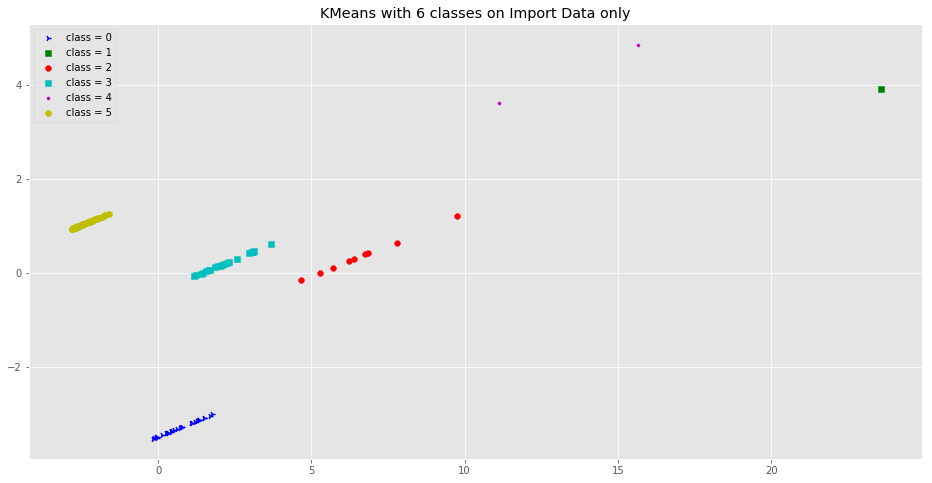

In [51]:
import_df, imp_model = cluster_year(df_comb, KMeans, year=2010, cond="^impo", n_clusters=6)
plot_cluster(import_df, title="KMeans with 6 classes on Import Data only");

* Import data is similarly easy to classify, but remains somewhat sparse

In [52]:
return_top_n(import_df, 'impo_total', sample_size=2)

,impo_total,population,impo_food,impo_resource,gdp,label
country,,,,,,
Luxembourg,19.690941,0.000070,2.259022,17.431919,0.923321,1
Belgium,14.903288,0.001504,3.955896,10.947393,0.390389,4
Netherlands,11.684243,0.002289,4.508624,7.175619,0.442799,4
Norway,6.698105,0.000673,1.590302,5.107803,0.772069,2
Austria,7.046785,0.001155,1.198581,5.848204,0.412185,2
Oman,3.558503,0.000405,1.104601,2.453902,0.169602,3
Malaysia,2.865595,0.003870,0.800173,2.065421,0.079796,3
Macedonia TFYR,1.864256,0.000284,0.507936,1.356320,0.039961,0
Fiji,1.367002,0.000118,0.783854,0.583148,0.032124,0


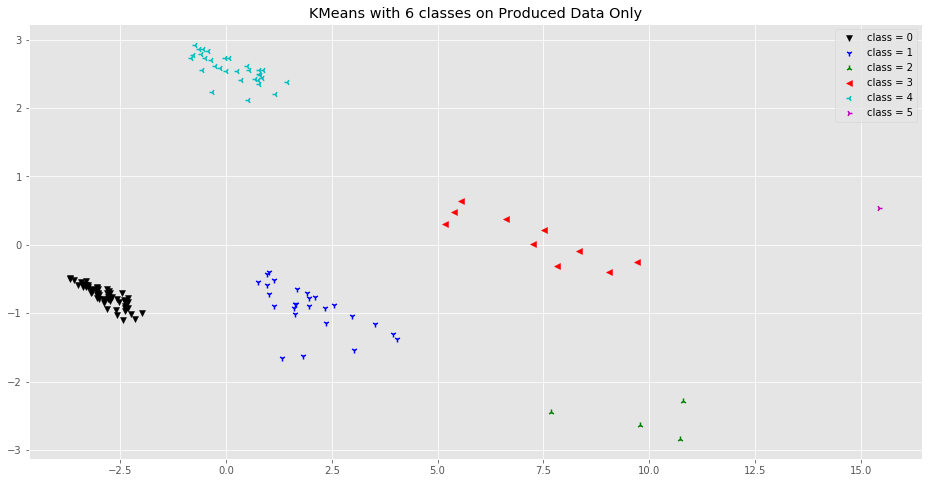

In [53]:
prod_df, prod_model = cluster_year(df_comb, KMeans, 2010, "^prod", n_clusters=6)
plot_cluster(prod_df, title="KMeans with 6 classes on Produced Data Only");

In [54]:
return_top_n(prod_df, 'prod_total')

,prod_total,population,prod_food,prod_resource,prod_industry,gdp,label
country,,,,,,,
Qatar,13.577056,0.000243,0.120408,13.405198,0.051451,0.618446,5
Canada,11.807862,0.004697,2.988588,8.760356,0.058919,0.417370,2
Norway,10.651029,0.000673,5.927138,4.668441,0.055449,0.772069,2
United Arab Emirates,7.454610,0.001146,0.189065,7.265544,0.000000,0.308308,3
Estonia,9.632812,0.000183,1.089441,8.490792,0.052579,0.128768,3
Austria,5.450245,0.001155,0.826941,4.481088,0.142216,0.412185,1
Slovakia,4.617501,0.000744,0.668679,3.867101,0.081721,0.146027,1
Barbados,2.135812,0.000039,0.188005,1.911474,0.036333,0.140383,4
Bahamas,1.884576,0.000050,0.139464,1.707186,0.037926,0.192833,4


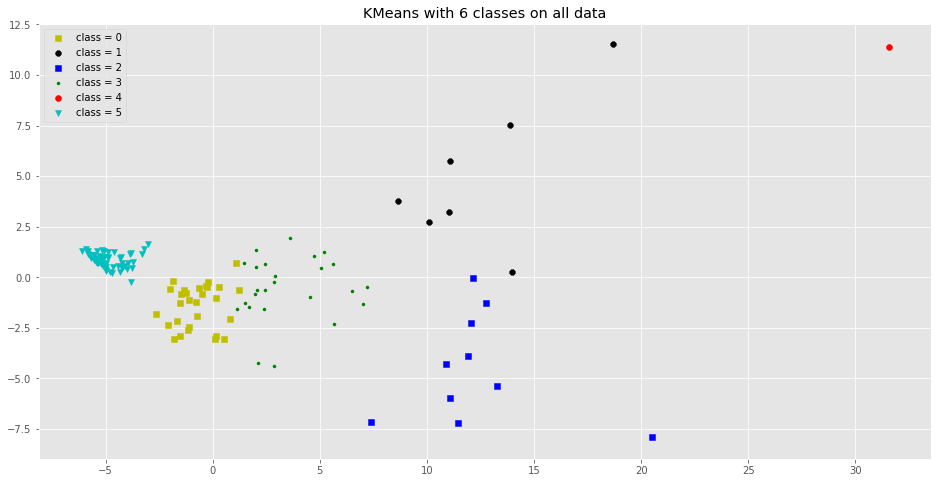

In [55]:
all_df2010, all_model2010 = cluster_year(df_comb, KMeans, year=2010, n_clusters=6)
plot_cluster(all_df2010, title="KMeans with 6 classes on all data");

In [56]:
all_df2010.columns

Index(['cons_total', 'prod_total', 'expo_total', 'impo_total', 'population',
       'cons_food', 'cons_resource', 'cons_industry', 'prod_food',
       'prod_resource', 'prod_industry', 'impo_food', 'impo_resource',
       'expo_food', 'expo_resource', 'gdp', 'label'],
      dtype='object')

In [57]:
return_top_n(all_df2010, 'impo_resource', sample_size=5).iloc[:,-9:]

,prod_food,prod_resource,prod_industry,impo_food,impo_resource,expo_food,expo_resource,gdp,label
country,,,,,,,,,
Luxembourg,0.518782,8.257683,0.109795,2.259022,17.431919,0.798713,12.689062,0.923321,4
Slovenia,0.388203,3.861157,0.024499,1.497744,5.560370,0.960357,5.225405,0.206167,1
Netherlands,0.410096,3.987015,0.093984,4.508624,7.175619,3.241299,6.426960,0.442799,1
Belgium,0.461975,4.029842,0.191874,3.955896,10.947393,2.562642,9.860134,0.390389,1
Austria,0.826941,4.481088,0.142216,1.198581,5.848204,0.823970,5.455143,0.412185,1
Norway,5.927138,4.668441,0.055449,1.590302,5.107803,4.987684,5.748352,0.772069,1
Bahrain,0.031980,7.987396,0.081709,1.005894,4.336148,0.041798,2.724521,0.182281,2
Estonia,1.089441,8.490792,0.052579,1.044616,3.345688,1.434638,6.505175,0.128768,2
United Arab Emirates,0.189065,7.265544,0.000000,1.665844,5.193787,0.691252,3.750690,0.308308,2


## Modeling and Evaluation 2 -- 10

 - Evaluate and Compare

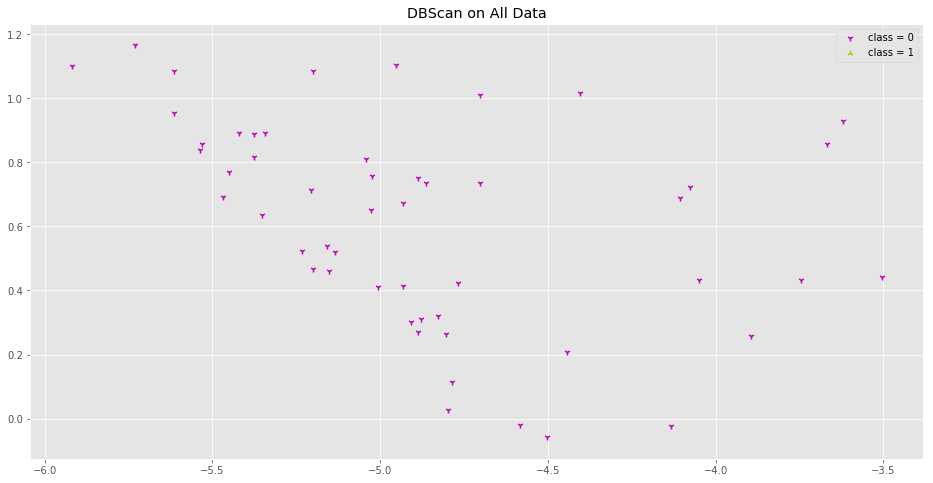

In [58]:
df_db_all, df_db_model = cluster_year(df_comb, DBSCAN, 2010, eps=1.5, min_samples=3, n_jobs=-1, metric='manhattan')
plot_cluster(df_db_all, title="DBScan on All Data");

## DBscan Failed

 - DBSCAN fails:
     - In cases of varying density clusters
     - In cases of high dimensional data
     
    Our data has both, and so DBSCAN only found 1 giant cluster, even when searching for 5+

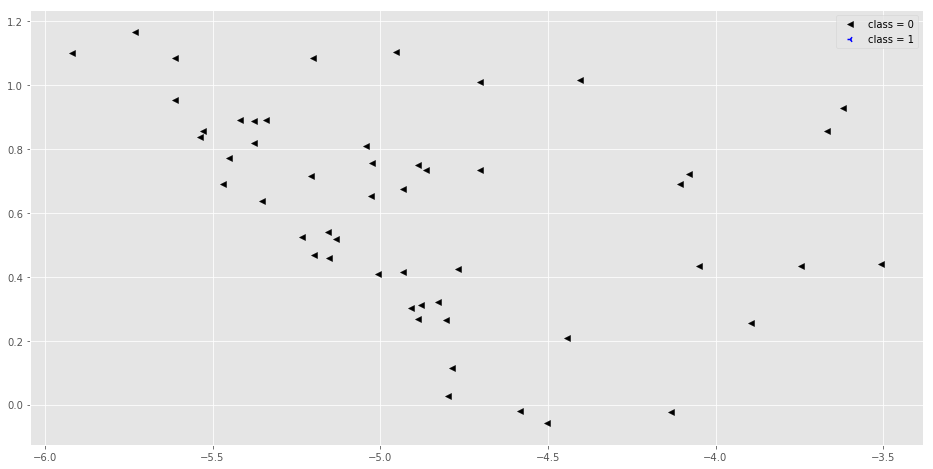

In [59]:
df_db_spectral, spectral_model =\
    cluster_year(df_comb, SpectralClustering, 2010, n_neighbors=3, degree=1, n_clusters=8, n_jobs=-1)
plot_cluster(df_db_all);

In [60]:
df_comb.columns

Index(['country', 'year', 'cons_total', 'prod_total', 'expo_total',
       'impo_total', 'population', 'cons_food', 'cons_resource',
       'cons_industry', 'prod_food', 'prod_resource', 'prod_industry',
       'impo_food', 'impo_resource', 'expo_food', 'expo_resource', 'gdp'],
      dtype='object')

## SpectralClustering Failed

 - SpectralClustering fails:
     - Data is too sparse
     - Dimensionality of data is too high
     - Kmeans and AgglomerativeClustering seem to give good results so we will move forward with those
     
    SpectralClustering either produces a single cluster or does not seem to produce meaningful relationships

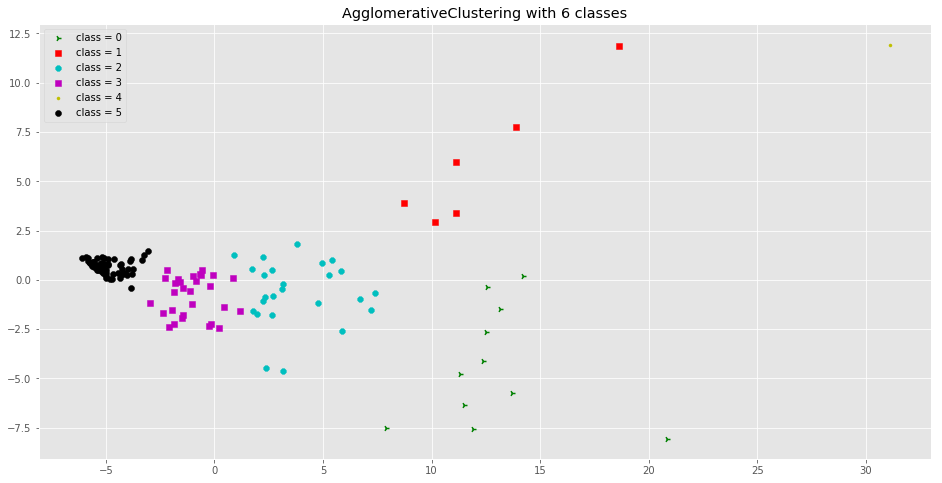

In [61]:
all_df_nopop_2010_algo, model_algo_nopop_2010 = \
    cluster_year(df_comb[[col for col in df_comb.columns if col not in {'gdp', 'population'}]]
                       , AgglomerativeClustering, year=2010, n_clusters=6)
plot_cluster(all_df_nopop_2010_algo, title="AgglomerativeClustering with 6 classes");

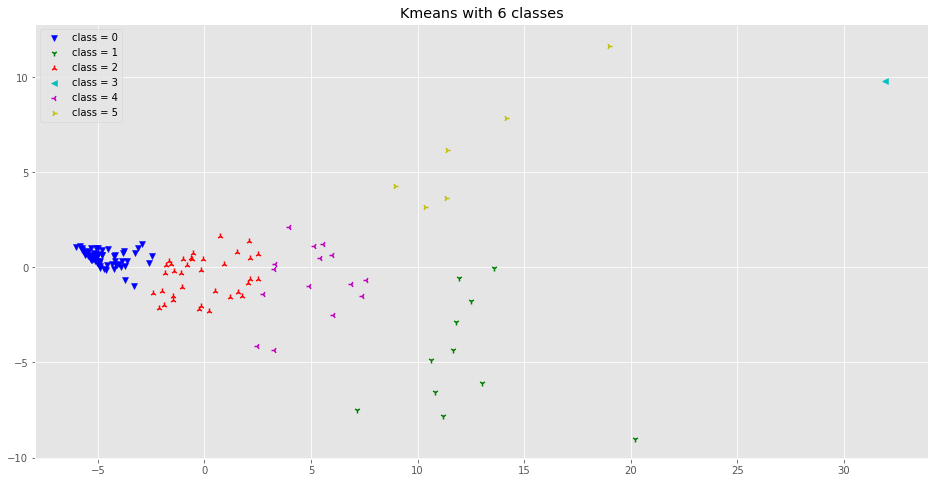

In [62]:
all_df_nopop_2010_kmeans, model_kmeans_nopop_2010 = \
    cluster_year(df_comb[[col for col in df_comb.columns if col not in {'gdp', 'population'}]]
                       , KMeans, year=2010, n_clusters=6)
plot_cluster(all_df_nopop_2010_kmeans, title="Kmeans with 6 classes");

- There's not to much difference between the two, but overall the Agglomerative seems to give slightly more balanced classes; because they are not size based, the relationships seem stronger, and the boundries are still well defined.  Agglomerative Clustering seems to be the best choice for this data set.

## Modeling and Evaluation 3 -- 10

 - Visualize Results

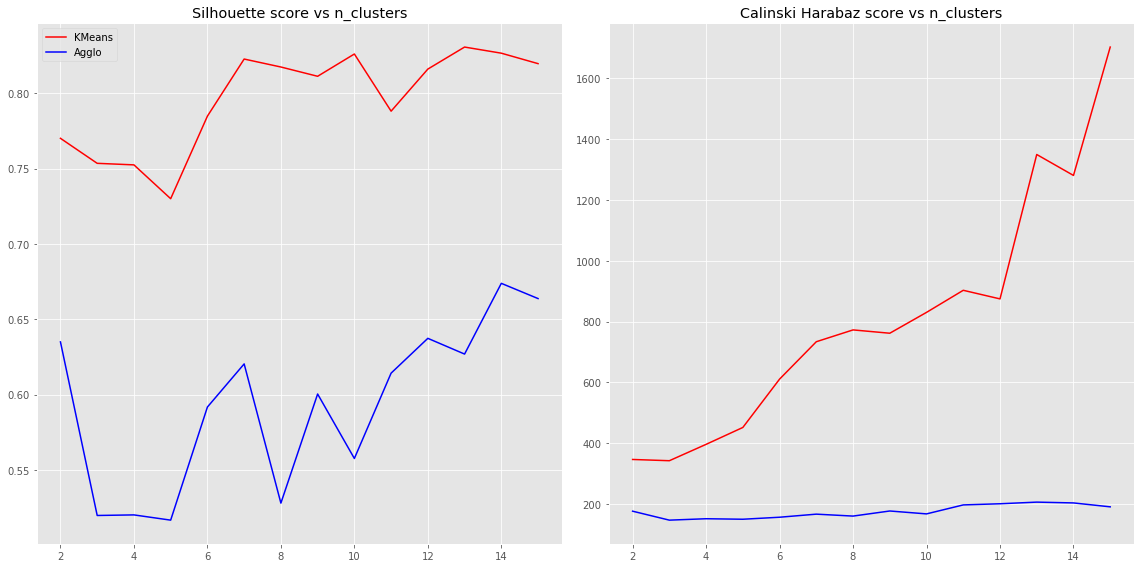

In [63]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabaz_score

xk = []
y1k = []
y2k = []
xag = []
y1ag = []
y2ag = []
for n in range(2,16):
    temp_df_kmeans, temp_model_kmeans = cluster_year(df_comb, KMeans, year=2010, 
                                      cond="^expo", init='k-means++',n_init=10,
                                      n_clusters=n,random_state=42)
    temp_df_aggo, temp_model_aggo = cluster_year(df_comb, KMeans, year=2010,
                                      n_clusters=n,random_state=42)
    s_scorek = silhouette_score(temp_df_kmeans, temp_model_kmeans.labels_, metric='euclidean')
    ch_scorek = calinski_harabaz_score(temp_df_kmeans, temp_model_kmeans.labels_)
    s_scorea = silhouette_score(temp_df_aggo, temp_model_aggo.labels_, metric='euclidean')
    ch_scorea = calinski_harabaz_score(temp_df_aggo, temp_model_aggo.labels_)
    xk.append(n)
    y1k.append(s_scorek)
    y2k.append(ch_scorek)
    xag.append(n)
    y1ag.append(s_scorea)
    y2ag.append(ch_scorea)
    #print("With %s clusters, the silhoutte score is %s" % (n,s_score) )


    
fig, ax = plt.subplots(1,2, figsize=(16,8))
# for xki, y1ki, y2ki, y1agi, y2agi in zip(xk, y1k, y2k, y1ag, y2ag):
ax[0].plot(xk, y1k, color='r', label='KMeans')
ax[0].plot(xk, y1ag, color='b', label="Agglo")
ax[1].plot(xk, y2k, color='r')
ax[1].plot(xk, y2ag, color='b')
ax[0].legend()
ax[0].set_title("Silhouette score vs n_clusters")
ax[1].set_title("Calinski Harabaz score vs n_clusters")
plt.tight_layout()

# plotobj = plt.plot(x,y1, size=(16,8))

* It appears that the diffirence between KMeans ang AgglomerativeClustering grows significently as the number of clusters increases.  This could be beacause clusters of equal size in KMeans start to make less and less sense; while AgglomerativeClustering seems to continue to find common ground in the clusters.

Estimated number of clusters: 6
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.489


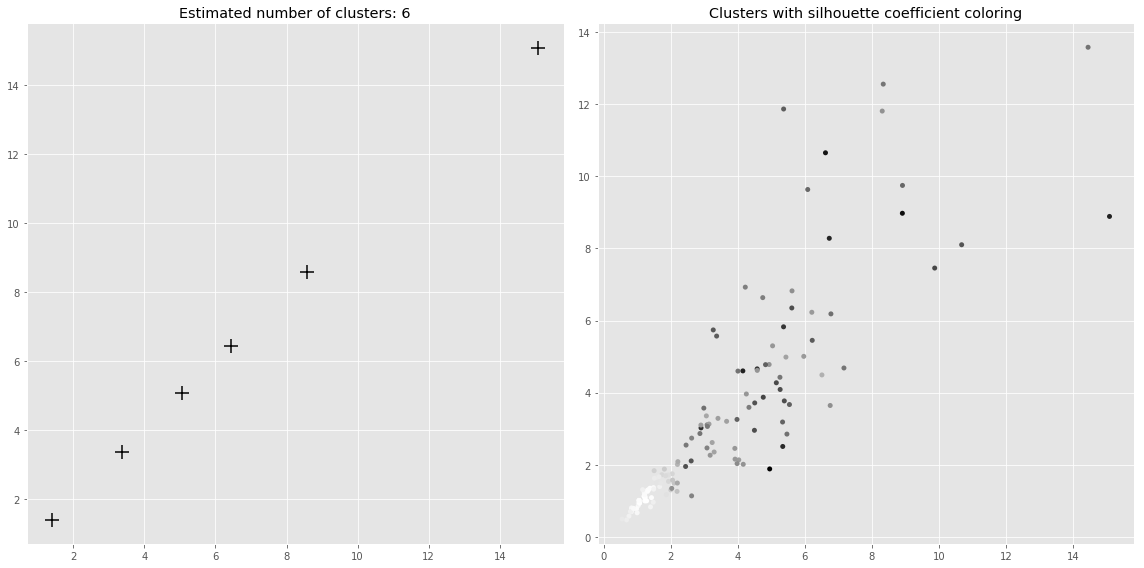

In [64]:
#cols = [col for col in df_comb.columns if re.search('.*', col)  or len(col.split('_')) == 1]
#all_df2 = df_comb[cols].set_index('country').query("year == " + str(2010)).drop('year', axis=1)
all_df2 = all_df_nopop_2010_algo.copy()


n_clusters = 6
model = KMeans(init='k-means++', n_clusters=n,random_state=42, n_init=10).fit(all_df2)
model = AgglomerativeClustering(linkage='ward', n_clusters=n_clusters).fit(all_df2)
# model = DBSCAN(eps=0.15, min_samples=10).fit(all_df2)

labels = model.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(model_algo_nopop_2010.labels_, labels))
print("Completeness: %0.3f" % metrics.completeness_score(model_algo_nopop_2010.labels_, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(model_algo_nopop_2010.labels_, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(model_algo_nopop_2010.labels_, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(model_algo_nopop_2010.labels_, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(all_df2, labels))

silhouette_per_sample = metrics.silhouette_samples(all_df2, labels)

# get the middle of each cluster
centroids = []
for lab in range(0, n_clusters_):
    centroids.append( [np.mean(all_df2.loc[all_df2['label'] == lab, all_df2.columns[0]]),
                       np.mean(all_df2.loc[all_df2['label'] == lab, all_df2.columns[0]])])

centroids = np.array(centroids)


fig, ax = plt.subplots(1, 2, figsize=(16,8))
ax[0].scatter(centroids[:, 0], centroids[:, 1],
                marker='+', s=200, linewidths=3, color='k', zorder=10)
ax[0].set_title('Estimated number of clusters: %d' % n_clusters_)
ax[1].scatter(all_df2.iloc[:, 0], all_df2.iloc[:, 1], c=silhouette_per_sample,
                cmap=plt.cm.gray, s=25, linewidths=0)
ax[1].set_title('Clusters with silhouette coefficient coloring')
plt.tight_layout()

CPU times: user 20.3 ms, sys: 4 µs, total: 20.3 ms
Wall time: 3.46 ms


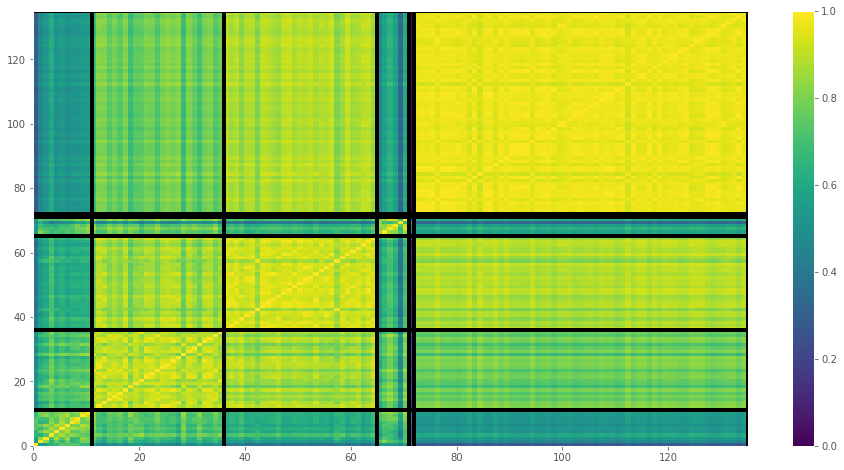

In [65]:
# plot the similarity matrix
from sklearn.metrics import pairwise

y=labels
idx_sorted = np.argsort(y,kind="quicksort")  # need to get the ordering of Y
all_df2_sorted = all_df2.iloc[idx_sorted]  # sort the dataset by class
%time R = pairwise.euclidean_distances(all_df2_sorted)  # calculate the similarity

#transform distance to similarity
min_r = np.min(R)
max_r = np.max(R)
R = 1-(R-min_r)/(max_r-min_r)

# plt.figure(figsize=(20,10))
plt.figure(figsize=(16,8))
plt.pcolormesh(R)
plt.colorbar()

# plot class boundaries
bounds = np.cumsum([np.sum(y==val) for val in np.unique(y)])
for b in bounds:
    plt.plot([b,b],[0, len(y)],'k',linewidth=4)
    plt.plot([0, len(y)],[b,b],'k',linewidth=4)

plt.show()

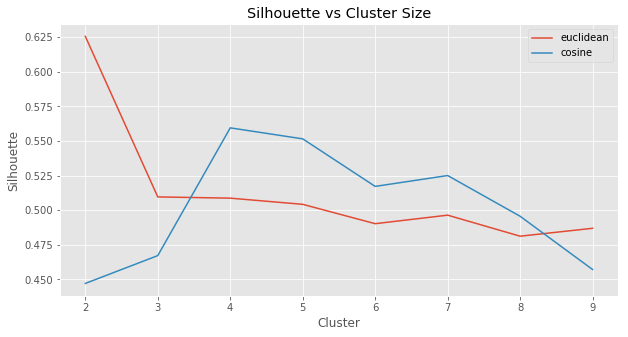

In [66]:
# do it for the k-means
from sklearn.cluster import KMeans

seuclid = []
scosine = []
k = range(2,10)
for i in k:
    kmeans_model = KMeans(n_clusters=i, init="k-means++").fit(all_df2)
    labels = kmeans_model.labels_
    seuclid.append(metrics.silhouette_score(all_df2, labels, metric='euclidean'))
    scosine.append(metrics.silhouette_score(all_df2, labels, metric='cosine'))
    
plt.figure(figsize=(10,5))
plt.plot(k,seuclid,label='euclidean')
plt.plot(k,scosine,label='cosine')
plt.ylabel("Silhouette")
plt.xlabel("Cluster")
plt.title("Silhouette vs Cluster Size")
plt.legend()
plt.show()

## Modeling and Evaluation 4 -- 20

 - Summarize the Ramifications

Our final model will be using agglomerative clustering with 6 clusters. Our metrics suggested 5 or 6 to be our best options, and using our domain knowledge of the countries, we found 6 to make more sense. The only difference between having 5 and 6 clusters was Qatar (the outlier on the bottom right of the plot below). With only 5 clusters, it was seen as a part of Class 1, which it should not be. Adding the 6th cluster helped.

In [67]:
AgglomerativeClustering()

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward',
            memory=Memory(cachedir=None), n_clusters=2,
            pooling_func=<function mean at 0x7fab8c20aae8>)

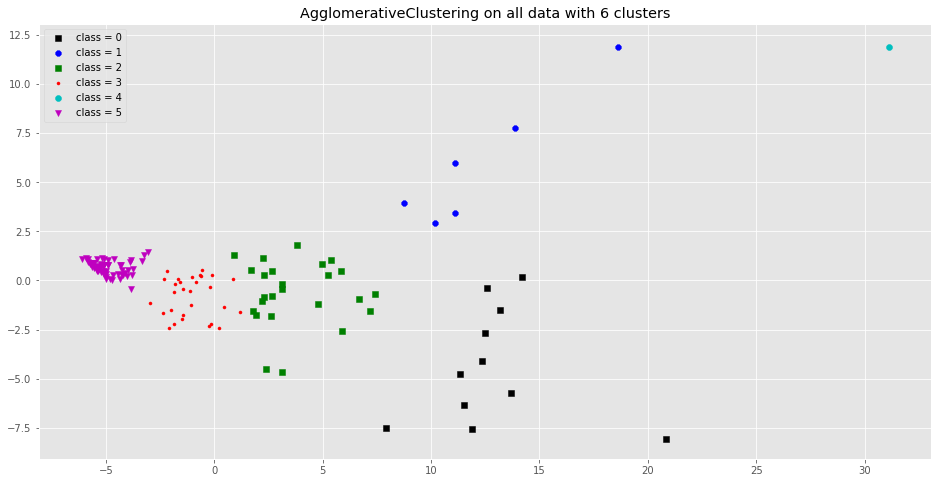

In [68]:
final_df, final_model = cluster_year(df_comb, AgglomerativeClustering, year=2010, n_clusters=6)
plot_cluster(final_df, title="AgglomerativeClustering on all data with 6 clusters");

Here's a look at each cluster, to see the similarities amongst the groups. 

In [69]:
return_top_n(final_df, sort_col="cons_total", sample_size=12)\
    .loc[:,[col for col in final_df.columns if col[-5:] == 'total' or col == 'label']]

,cons_total,prod_total,expo_total,impo_total,label
country,,,,,
Luxembourg,15.089424,8.886259,13.487775,19.690941,4
Australia,8.337228,12.555085,6.457087,2.239230,0
Bahrain,10.676807,8.101085,2.766320,5.342041,0
Canada,8.306780,11.807862,7.171179,3.670096,0
Estonia,6.083304,9.632812,7.939813,4.390304,0
Kuwait,8.911158,9.745996,3.987335,3.152498,0
New Zealand,5.363766,11.864901,9.141135,2.640000,0
Norway,6.613097,10.651029,10.736036,6.698105,0
Qatar,14.449905,13.577056,5.450877,6.323726,0


In [70]:
# final_df[final_df['label'] == 0].iloc[:,0:4].sample(7)
# final_df[final_df['label'] == 1].iloc[:,0:4].sample(7)
# final_df[final_df['label'] == 2].iloc[:,0:4].sample(7)
# final_df[final_df['label'] == 3].iloc[:,0:4]
# final_df[final_df['label'] == 4].iloc[:,0:4]
# final_df[final_df['label'] == 5].iloc[:,0:4]

 - It looks like the 6 clusters are as follows:
     - Class 0: Medium-large consumers - Primarily Industralized, but not resource rich countries, low imports/exports
     - Class 1: Exteremly large consumers and producers, very wealthy countries
     - Class 2: Small consumers, very low imports/exports and Developing Nations
     - Class 3: Resource rich nations and semi-industralized nations
     - Class 4: Large consumers - Resource Rich Developed Countries with high imports/exports
     - Class 5: Qatar


#### Deployment 10

- Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling?

Since we were clustering, instead of classifying, our results were more explanatory than anything, and we were pleased with how it turned out. Visually and analytically, our clusters made a lot of sense. To really test if we did well, we'd need an outside source to tell us how these countries should be classified, for us to compare.

- How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)? 
- How would your deploy your model for interested parties?
 
This information could be interesting to governments and environmentallists to see whether their countries footprint is too large in comparison to similar countries. They could use this to enact policies to help their future impact on the environment.

- What other data should be collected?
- How often would the model need to be updated, etc.?

it could also be useful for identifying new catagories to apply to a country based on it's ecological footprint.  Using some of the clusters identified, funding and effort could be allocated according to need and by the impact of the enviromential issues.
 
This data needs to be gathered yearly, and for every country. There are still some countries that are not involved, and getting their data would make this a more complete endeavour.

## Exceptional Work 10

 - You have free reign to provide additional analyses or combine analyses

* so far we have been working in 2010, but because we've got it all reduced to functions, we're going to plot each cluster every 5 years and print which countries may have moved to see how the clusters changed over time

In [71]:
years = df_comb['year'].sort_values().unique()[::5]

In [72]:
## replace 1991 because that year had a lot of nulls
years[6] = 1990

In [73]:
years.shape

(11,)

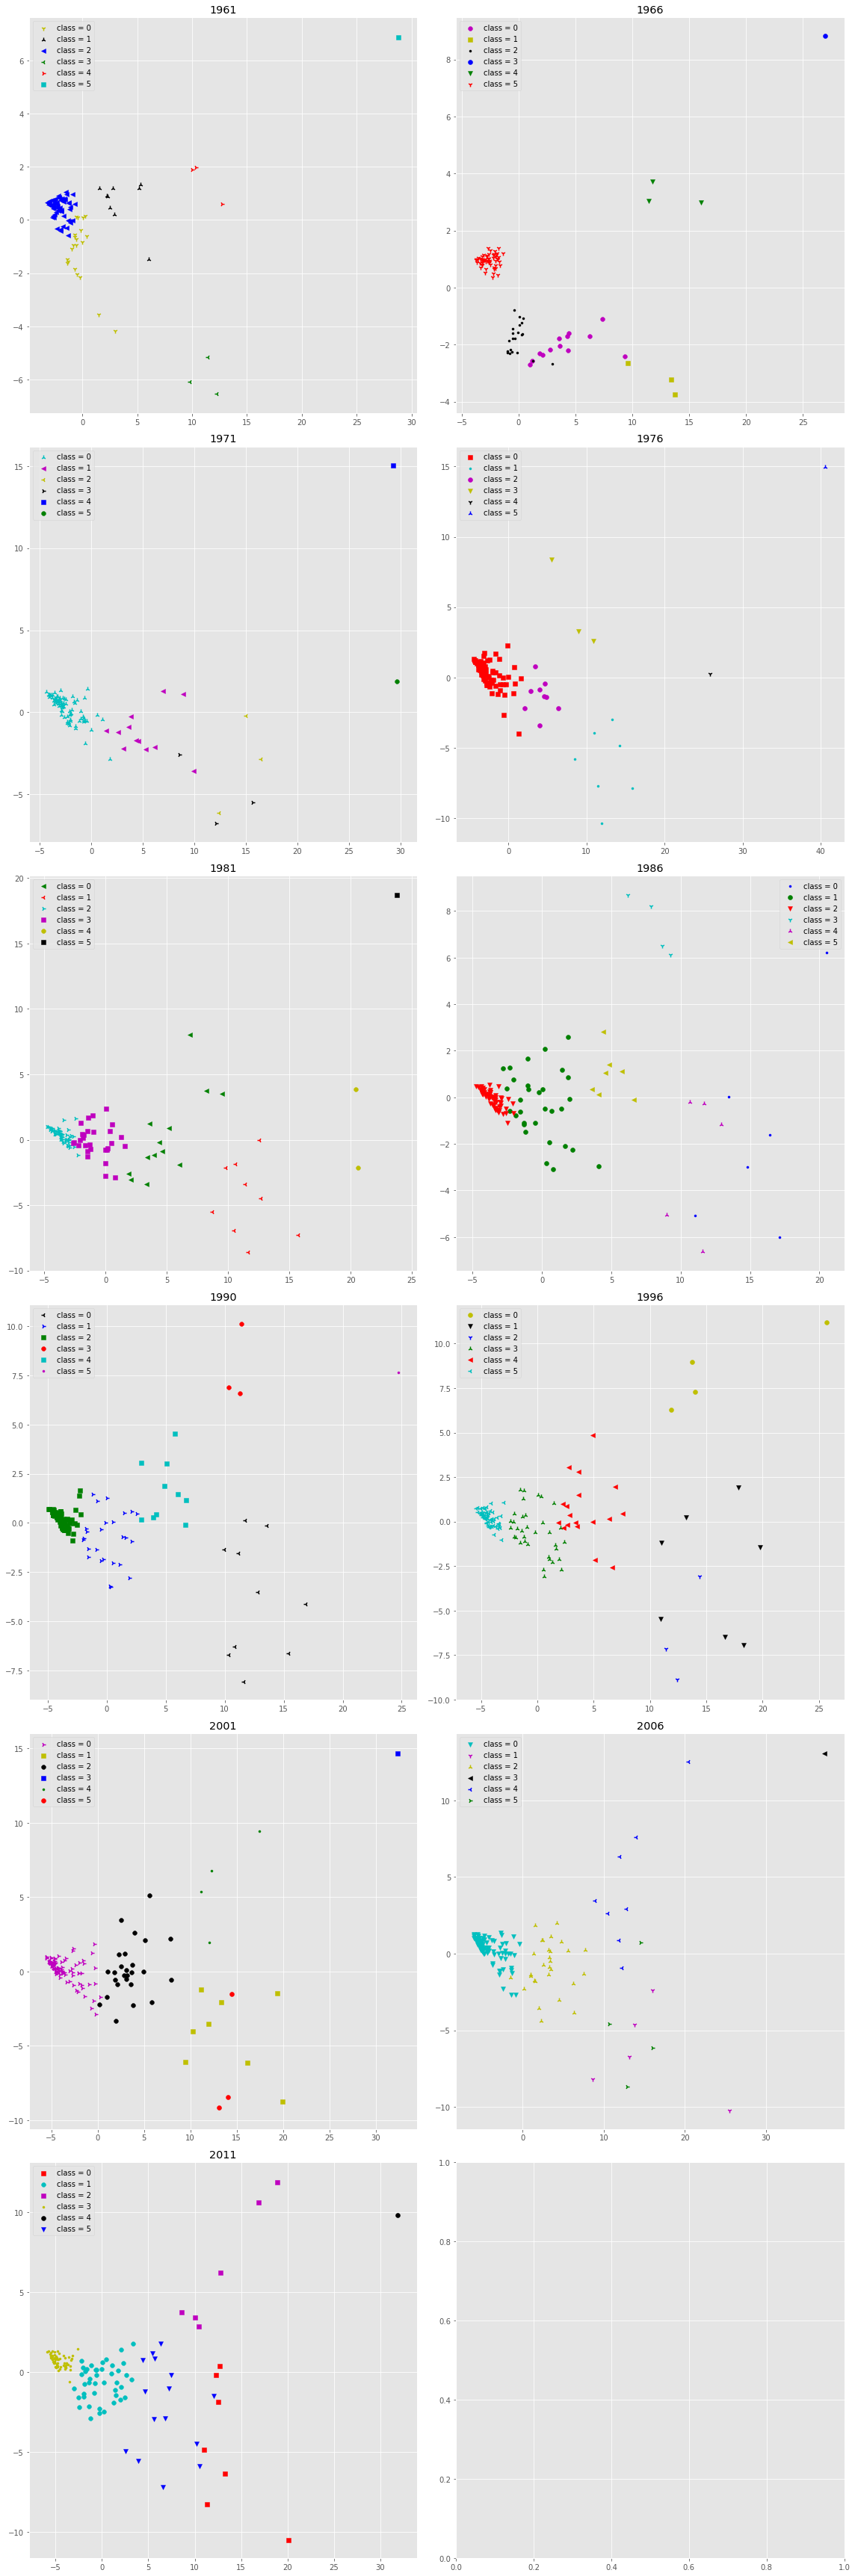

In [74]:
fig, axs = plt.subplots(6, 2, figsize=(16, 8 * 6))
dfs = {}
models = {}
idx = []
for idx2, iyear in enumerate(years):
    idx1 =  int(idx2 / 2)
    idx2 %= 2
    dfi, modeli = cluster_year(df_comb, 
                               AgglomerativeClustering,
                               iyear,
                               n_clusters=6 )
    dfs[iyear] = dfi
    models[iyear] = modeli
    plot_cluster(dfi, ax= axs[idx1, idx2], fig=fig, title=iyear);
plt.tight_layout()

* The clusters seem to change a lot every 5 years. Historically it appears more countries were clustered toward a single point while in the 70's and 80's they seemed to spread out more, and in the early 2000's they seem to get closer together agian

In [75]:
## Normalize all cluster IDs by consumption rank
for year in years:
    mapi = {k:v for k,v in zip(np.arange(6),
                          dfs[year].groupby('label')\
                           .agg({'cons_total': 'mean'})\
                            ['cons_total'].sort_values(ascending=False).index)}
    dfs[year]['label'] = dfs[year]['label'].replace(mapi)

In [78]:
for idx, year in enumerate(years[1:]):
    print("In", str(year))
    for i in range(6):
        dfs[year]['label']
        gonei= set(dfs[years[idx]].query("label == {}".format(i))['label'].index) - \
                        set(dfs[year].query("label == {}".format(i))['label'].index)
        if gonei:
            print("\t" + ', '.join([x.split()[0][:8] for x in list(gonei)[:8]]), "joined group ", str(i))
        else:
            print("\t" + "group {} was unchanged".format(i))

In 1966
	United, Sweden, Canada joined group  0
	Australi, Norway, New joined group  1
	Luxembou joined group  2
	Malaysia, Congo, CÃṀte, Syrian, Albania, Nigeria, India, Afghanis joined group  3
	Netherla, Germany, Denmark, France, Poland, United, Switzerl, Belgium joined group  4
	Panama, Colombia, Spain, Chad, Bolivia, Guyana, Somalia, Japan joined group  5
In 1971
	group 0 was unchanged
	Malaysia, Panama, Colombia, Spain, Chad, Bolivia, Guyana, Somalia joined group  1
	United, Sweden, Canada joined group  2
	Netherla, Germany, Italy, Denmark, France, Japan, Poland, United joined group  3
	group 4 was unchanged
	group 5 was unchanged
In 1976
	Luxembou joined group  0
	Bahamas joined group  1
	Ireland, Germany, Denmark, France, Japan, Poland, United, Switzerl joined group  2
	United, Sweden, Canada joined group  3
	group 4 was unchanged
	group 5 was unchanged
In 1981
	Bahamas joined group  0
	Ireland, Germany, France, Japan, Poland, United, Switzerl, Romania joined group  1
	Netherla

* Over the year, there have been a lot of movements.  The output above limits the amount of country names printed to 8 to make it more readable, and in some cases United could be the UAE while other times it could be the United States, but there is still some interesting data. The group rankings here are by total consumption.

* Singapore has beem moving up into the more elite ranks of group 2 
* The bahamas was once in the highest echelon of consumers in 1981 and 1990, but it has moved down over time
* In 2001, Canada, and the US placed in the same ranks as the UAE, Bahrain, Denmark and Qatar for total consumption
* Argentina went from being in the 2nd largest group for overall consumption down to the 2nd smallest in overall consumption in 2011.